# Rigidity loss Grid calculation with CRPropa3 

Based on the notebook `energy_loss.ipynb` but now doing instead for rigidity.

Calculate energy * Distance grid for rigidity loss based on CRPropa3

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from astropy import units as u
import h5py

from crpropa import *

# Evaluate energy loss over grid of distances

Again iterate over different compositions.

In [19]:
# initial parameters
N_grid = 20

# go up to 10ZeV
Esrc_range = 10**np.linspace(1, 4, N_grid) * u.EeV

# up to 100 Mpc
D_range = 10**np.linspace(0, np.log10(100), N_grid) * u.Mpc
# Threshhold energy at arrival (TA)
Eth = 57 * u.EeV

# simulation parameters
N_sim = 1_000

# doesnt matter since it will access it for each iteration
sim_file_name = "output/crpropa_events_grid.txt"

# particle parameters
# particles to simulate
known_ptypes = {
    "p": (1, 1),
    "He": (4, 2),
    "N" : (14, 7),
    "Fe" : (56, 26)
}


In [3]:


# nitrogen_fraction = np.zeros((N_grid, N_grid))
source_particle_fraction = np.zeros((N_grid, N_grid, len(known_ptypes)))
mean_arrival_energy = np.zeros((N_grid, N_grid, len(known_ptypes)))
mean_arrival_energy_maxA = np.zeros((N_grid, N_grid, len(known_ptypes)))
mean_arrival_energy_mcA = np.zeros((N_grid, N_grid, len(known_ptypes)))
fraction_above_Eth = np.zeros((N_grid, N_grid, len(known_ptypes)))
mean_charge = np.zeros((N_grid, N_grid, len(known_ptypes)))
mean_mass_number = np.zeros((N_grid, N_grid, len(known_ptypes)))
mean_energy_per_nucleon = np.zeros((N_grid, N_grid, len(known_ptypes)))
mean_rigidity = np.zeros((N_grid, N_grid, len(known_ptypes)))
mean_rigidity_nuclei = np.zeros((N_grid, N_grid, len(known_ptypes)))

E_arr = []
for k, (pt, ptup) in enumerate(list(known_ptypes.items())):
    for i, Esrc in enumerate(Esrc_range):
        print(f"Particle: {pt}, Esrc: {Esrc:.2f}")
        for j, D in enumerate(D_range):
            
            # construct simulation
            sim = ModuleList()
            sim.add( SimplePropagation(1*kpc, min([D.to_value(u.Mpc)/10, 10]) * Mpc) )
            sim.add( Redshift() )
            sim.add( PhotoPionProduction(CMB()) )
            sim.add( PhotoPionProduction(IRB_Kneiske04()) )
            sim.add( PhotoDisintegration(CMB()) )
            sim.add( PhotoDisintegration(IRB_Kneiske04()) )
            sim.add( NuclearDecay() )
            sim.add( ElectronPairProduction(CMB()) )
            sim.add( ElectronPairProduction(IRB_Kneiske04()) )
            sim.add( MinimumEnergy( 1 * EeV) )

            # add observer and output
            obs = Observer()
            obs.add( ObserverPoint() )
            output = TextOutput(sim_file_name, Output.Event1D)
            obs.onDetection( output )
            sim.add( obs )

            # define source properties (source comp., position, energy)
            source = Source()
            source.add( SourcePosition(D.to_value(u.Mpc) * Mpc) )
            source.add( SourceRedshift1D() )
            particle_type = nucleusId(*ptup) 
            source.add( SourceEnergy(Esrc.to_value(u.EeV) * EeV) )
            source.add( SourceParticleType(particle_type) ) 
            
            # run simulation
            sim.setShowProgress(False)
            sim.run(source, N_sim, True)
            output.close()

            # now open simulation file
            sim_data = np.genfromtxt(sim_file_name, names=True)

            # get observational parameters
            Z = np.array([chargeNumber(int(id)) for id in sim_data['ID'].astype(int)])  
            A = np.array([massNumber(int(id)) for id in sim_data['ID'].astype(int)])  
            E = 10**(np.log10(sim_data['E']) + 18)
            # fix Z == 0 bug
            Z[np.argwhere(Z == 0)] = 1 
            R = E / Z  # rigidity
            E_per_A = E / A

            # maximum mass number
            idx_max_A = A[A==max(A)]
            A_list = list(A)
            # not too sure what this is below
            A_mc = max(set(A_list), key=A_list.count)
            idx_mc_A = A[A==A_mc]
            
            # A / Z
            A_per_Z = A / Z

            # append all physical variables

            # fraction of source particles remaining
            source_particle_fraction[i][j][k] = N_sim / len(A)

            # mean arrival energy
            mean_arrival_energy[i][j][k] = np.mean(E)

            # mean arrival energy with largest A 
            mean_arrival_energy_maxA[i][j][k] = np.mean(E[idx_max_A])

            # mean arrival energy with ?
            mean_arrival_energy_mcA[i][j][k] = np.mean(E[idx_mc_A])

            # all energy fraction greater than the threshhold energy
            fraction_above_Eth[i][j][k] = len(E[E>Eth.to_value(u.eV)]) / len(E)

            # average charge, mass number, E/A, rigidity
            mean_charge[i][j][k] = np.mean(Z)
            mean_mass_number[i][j][k] = np.mean(A)
            mean_energy_per_nucleon[i][j][k] = np.mean(E/A)
            mean_rigidity[i][j][k] = np.mean(R)

            # mean rigidity for those that are not protons A / Z > 1
            mean_rigidity_nuclei[i][j][k] = np.mean(R[A_per_Z > 1])

Particle: p, Esrc: 10.00 EeV
crpropa::ModuleList: Number of Threads: 128


/home/iwsatlas1/watanabe/.conda/envs/uhecr_env1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/iwsatlas1/watanabe/.conda/envs/uhecr_env1/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


crpropa::ModuleList: Number of Threads: 128
crpropa::ModuleList: Number of Threads: 128
crpropa::ModuleList: Number of Threads: 128
crpropa::ModuleList: Number of Threads: 128
crpropa::ModuleList: Number of Threads: 128
crpropa::ModuleList: Number of Threads: 128
crpropa::ModuleList: Number of Threads: 128
crpropa::ModuleList: Number of Threads: 128
crpropa::ModuleList: Number of Threads: 128
crpropa::ModuleList: Number of Threads: 128
crpropa::ModuleList: Number of Threads: 128
crpropa::ModuleList: Number of Threads: 128
crpropa::ModuleList: Number of Threads: 128
crpropa::ModuleList: Number of Threads: 128
crpropa::ModuleList: Number of Threads: 128
crpropa::ModuleList: Number of Threads: 128
crpropa::ModuleList: Number of Threads: 128
crpropa::ModuleList: Number of Threads: 128
crpropa::ModuleList: Number of Threads: 128
Particle: p, Esrc: 14.38 EeV
crpropa::ModuleList: Number of Threads: 128
crpropa::ModuleList: Number of Threads: 128
crpropa::ModuleList: Number of Threads: 128
crp

In [4]:
# Save
with h5py.File("output/energyloss_crpropa_results.h5", "w") as f:
    f.create_dataset("Esrc_range", data=Esrc_range.to_value(u.EeV))
    f.create_dataset("D_range", data=D_range.to_value(u.Mpc))
    f.create_dataset("Eth", data=Eth.to_value(u.EeV))
    f.create_dataset("source_particle_fraction", data=source_particle_fraction)
    f.create_dataset("mean_arrival_energy", data=mean_arrival_energy)
    f.create_dataset("mean_arrival_energy_maxA", data=mean_arrival_energy_maxA)
    f.create_dataset("mean_arrival_energy_mcA", data=mean_arrival_energy_mcA)
    f.create_dataset("fraction_above_Eth", data=fraction_above_Eth)
    f.create_dataset("mean_mass_number", data=mean_mass_number)
    f.create_dataset("mean_charge", data=mean_charge)
    f.create_dataset("mean_energy_per_nucleon", data=mean_energy_per_nucleon)
    f.create_dataset("mean_rigidity", data=mean_rigidity)
    f.create_dataset("mean_rigidity_nuclei", data=mean_rigidity_nuclei)

### Load output file and plot 2D histograms

Objective: to observe if we can just use mass number for energy loss, if rigidity ~ constant 

In [4]:
# Load
with h5py.File("output/energyloss_crpropa_results.h5", "r") as f:
    Esrc_range = f["Esrc_range"][()] * u.EeV
    D_range = f["D_range"][()] * u.Mpc
    Eth = f["Eth"][()] * u.EeV
    source_particle_fraction = f["source_particle_fraction"][()]
    mean_arrival_energy = f["mean_arrival_energy"][()] * u.eV
    mean_arrival_energy_maxA = f["mean_arrival_energy_maxA"][()] * u.eV
    mean_arrival_energy_mcA = f["mean_arrival_energy_mcA"][()] * u.eV
    fraction_above_Eth = f["fraction_above_Eth"][()]
    mean_charge = f["mean_charge"][()]
    mean_mass_number = f["mean_mass_number"][()]
    mean_energy_per_nucleon = f["mean_energy_per_nucleon"][()] * u.eV
    mean_rigidity = f["mean_rigidity"][()] * u.V
    mean_rigidity_nuclei = f["mean_rigidity_nuclei"][()] * u.V

## As last time, looking at $<E>$ and $<A>$

Basically the same contour plot as in `energy_loss.ipynb`, but also plotting $<E>$ (mainly for curiosity)

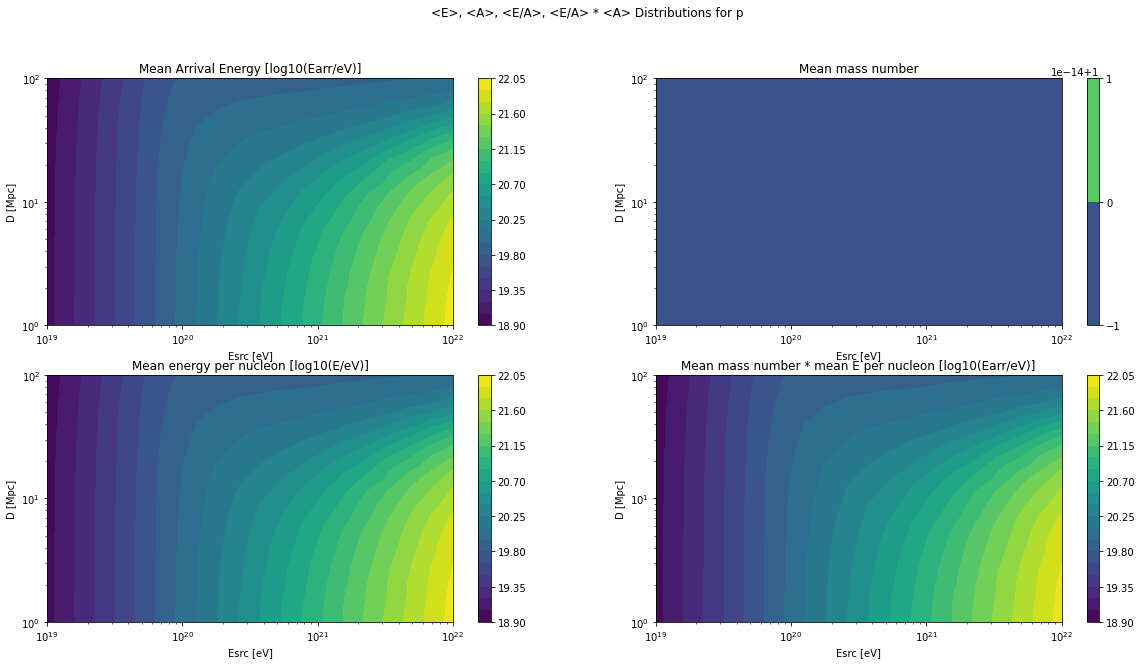

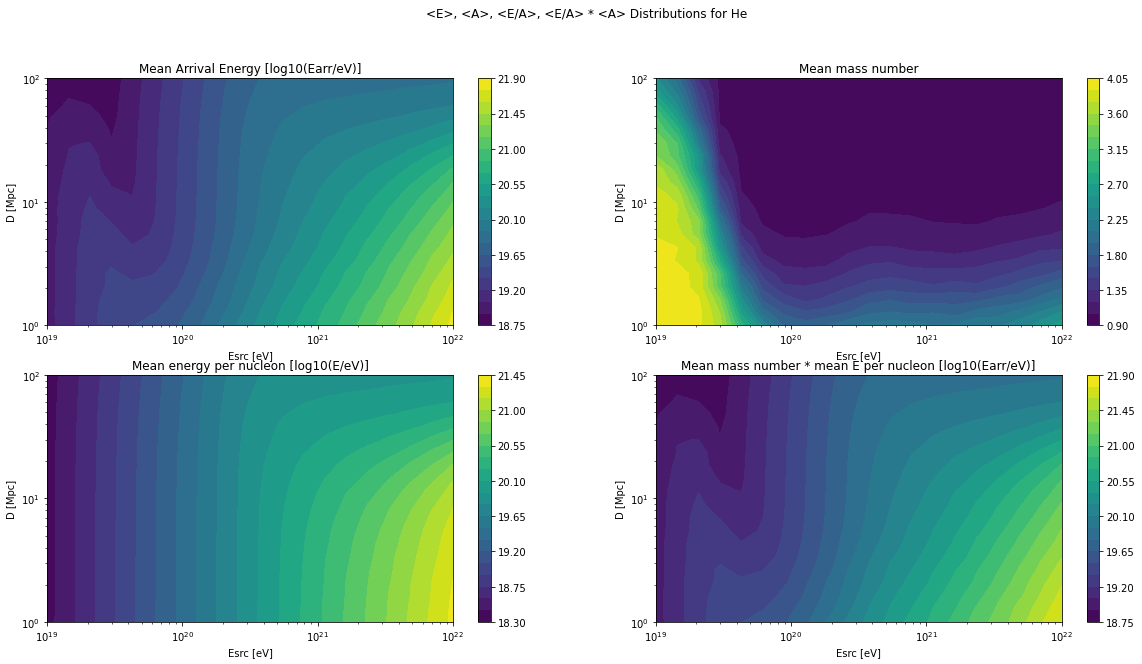

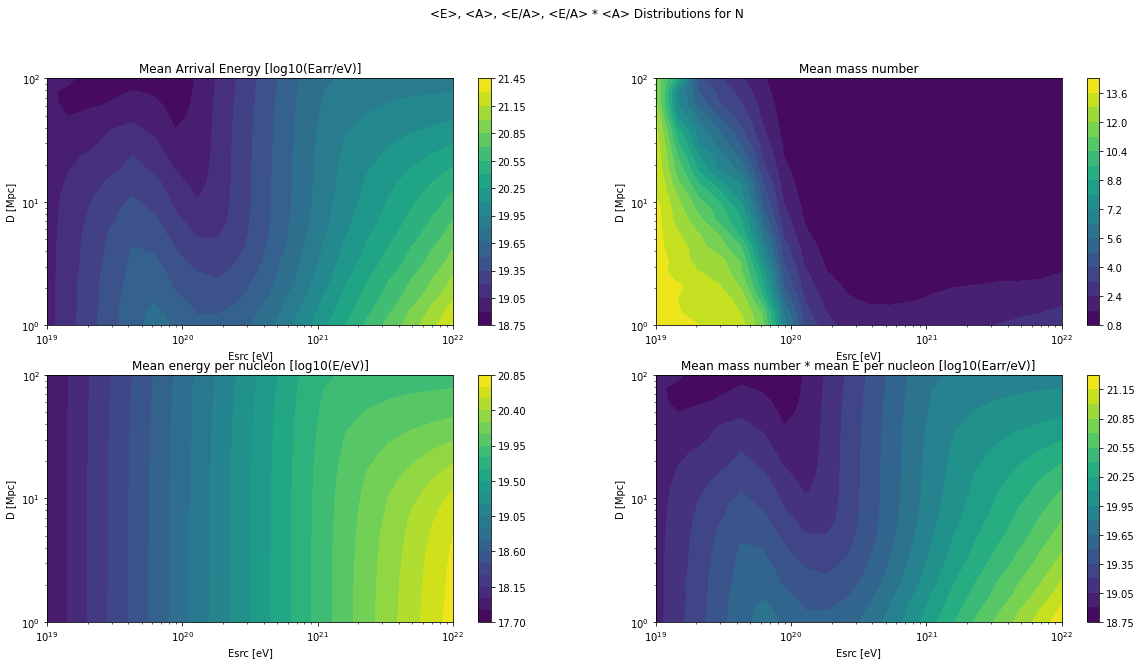

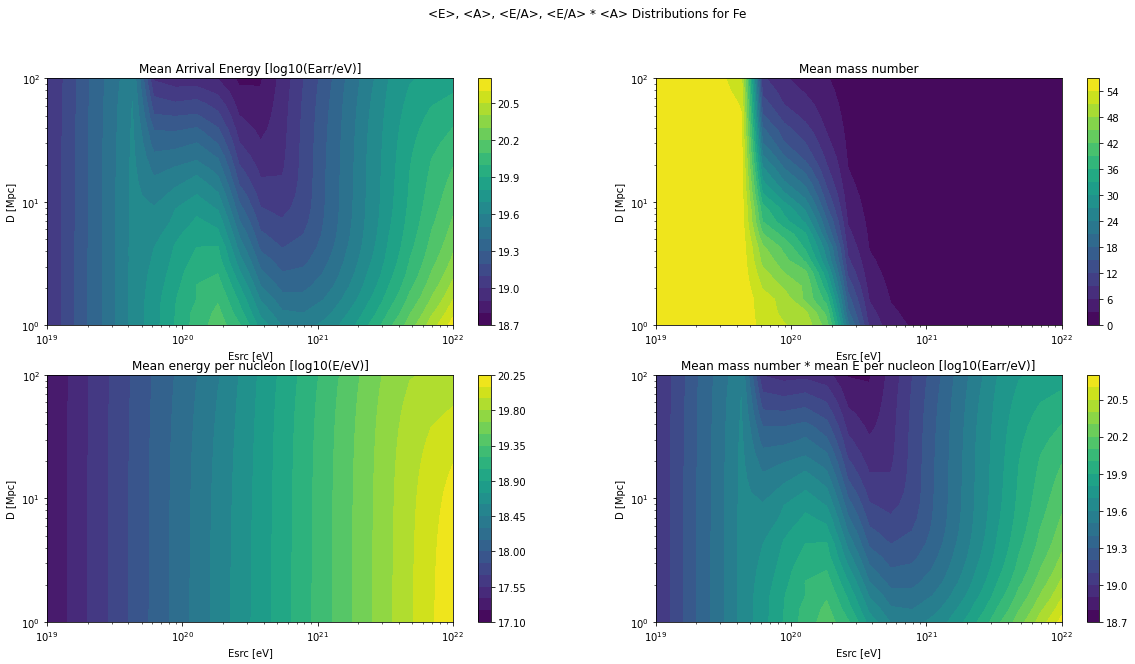

In [40]:
# plot <E>, <A>, <E/A>, <E / A> * <A>

for k, (pt, ptup) in enumerate(list(known_ptypes.items())):
    fig, ax = plt.subplots(2,2)
    fig.set_size_inches(20, 10)

    fig.suptitle(f"<E>, <A>, <E/A>, <E/A> * <A> Distributions for {pt}")

    our_approx = mean_mass_number[:,:,k] *  mean_energy_per_nucleon[:,:,k].to_value(u.eV)

    h0 = ax[0][0].contourf(Esrc_range.to_value(u.eV), D_range.to_value(u.Mpc), np.log10(mean_arrival_energy[:,:,k].to_value(u.eV)).T, levels=20)
    fig.colorbar(h0, ax=ax[0][0])
    ax[0][0].set_title("Mean Arrival Energy [log10(Earr/eV)]")

    h1 = ax[0][1].contourf(Esrc_range.to_value(u.eV), D_range.to_value(u.Mpc), mean_mass_number[:,:,k].T, levels=20)
    fig.colorbar(h1, ax=ax[0][1])
    ax[0][1].set_title("Mean mass number")

    h2 = ax[1][0].contourf(Esrc_range.to_value(u.eV), D_range.to_value(u.Mpc), np.log10(mean_energy_per_nucleon[:,:,k].to_value(u.eV)).T, levels=20)
    fig.colorbar(h2, ax=ax[1][0])
    ax[1][0].set_title("Mean energy per nucleon [log10(E/eV)]")

    h3 = ax[1][1].contourf(Esrc_range.to_value(u.eV), D_range.to_value(u.Mpc), np.log10(our_approx).T, levels=20)
    fig.colorbar(h3, ax=ax[1][1])
    ax[1][1].set_title("Mean mass number * mean E per nucleon [log10(Earr/eV)]")

    for (i,j) in np.ndindex(2,2):
        ax[i][j].set_xlabel("Esrc [eV]")
        ax[i][j].set_ylabel("D [Mpc]")
        ax[i][j].set_xscale("log")
        ax[i][j].set_yscale("log")

## Rigidity

Look at rigidity and rigidity for nuclei only.

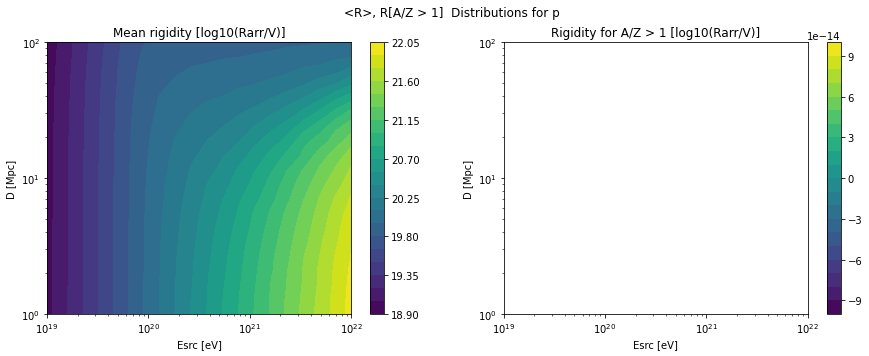

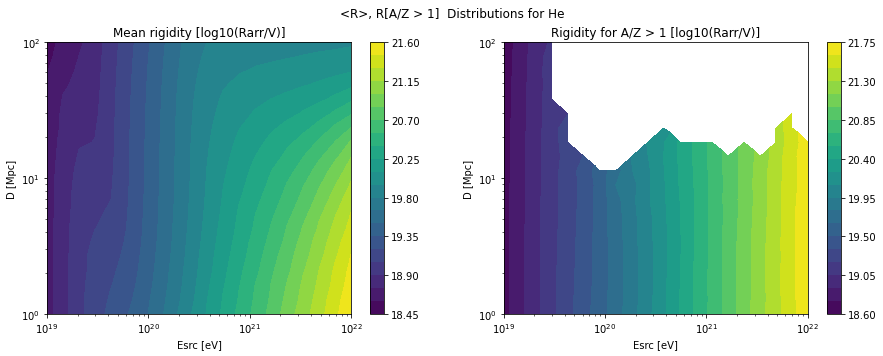

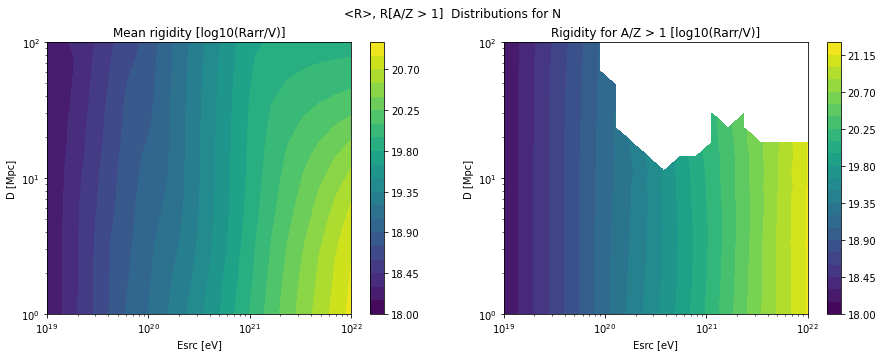

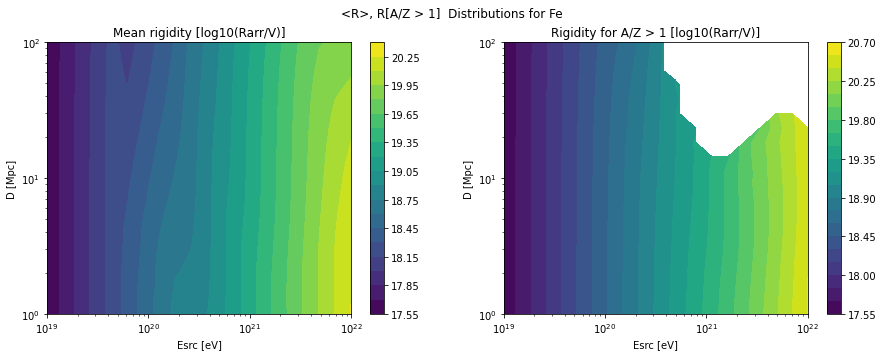

In [50]:
# Do similar for rigidity, except we compare <E/Z> vs <E> / <Z>

for k, (pt, ptup) in enumerate(list(known_ptypes.items())):
    fig, ax = plt.subplots(1,2, figsize=(15,5))
    # fig.set_size_inches(20, 10)

    fig.suptitle(f"<R>, R[A/Z > 1]  Distributions for {pt}")

    h2 = ax[0].contourf(Esrc_range.to_value(u.eV), D_range.to_value(u.Mpc), np.log10(mean_rigidity[:,:,k].to_value(u.V)).T, levels=20)
    fig.colorbar(h2, ax=ax[0])
    ax[0].set_title("Mean rigidity [log10(Rarr/V)]")

    h3 = ax[1].contourf(Esrc_range.to_value(u.eV), D_range.to_value(u.Mpc), np.log10(mean_rigidity_nuclei[:,:,k].to_value(u.V)).T, levels=20)
    fig.colorbar(h3, ax=ax[1])
    ax[1].set_title("Rigidity for A/Z > 1 [log10(Rarr/V)]")

    for i in range(2):
        ax[i].set_xlabel("Esrc [eV]")
        ax[i].set_ylabel("D [Mpc]")
        ax[i].set_xscale("log")
        ax[i].set_yscale("log")

## Rigidity fraction

Fraction between arrival rigidity vs source rigidity. Again we also plot for A / Z > 1 (nuclei.)

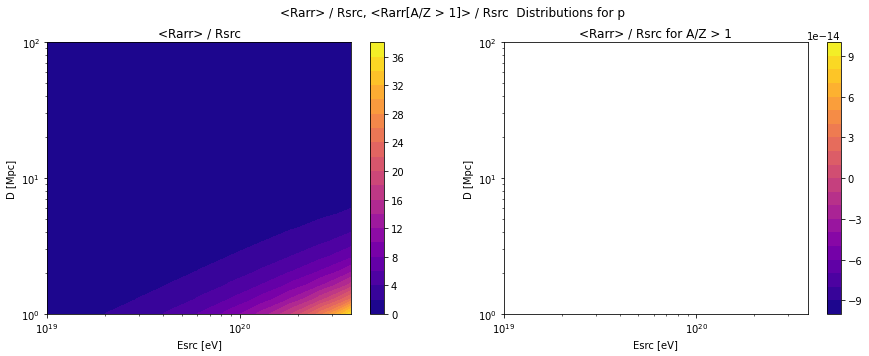

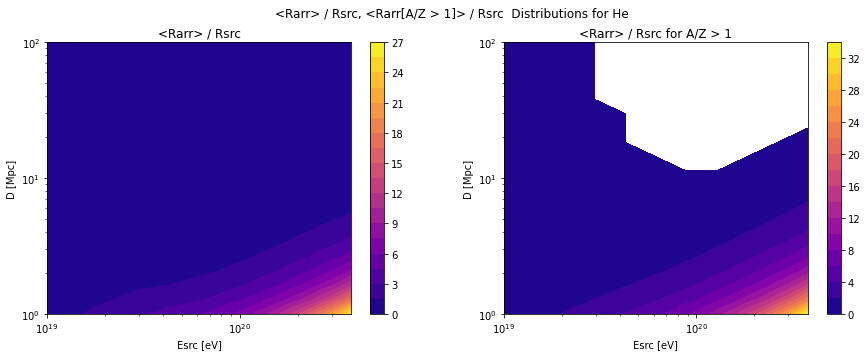

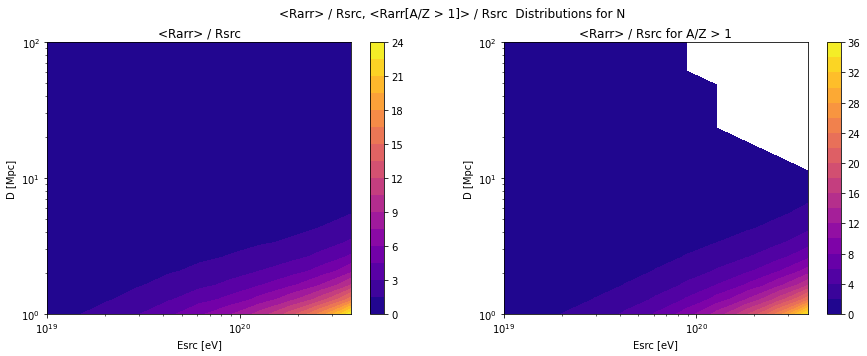

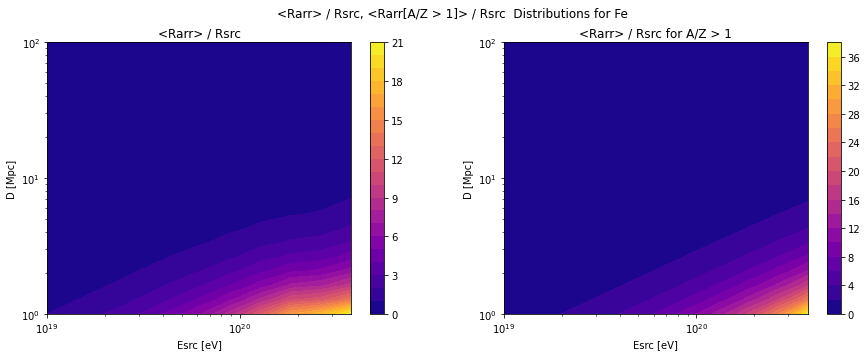

In [49]:
# For rigidity


for k, (pt, ptup) in enumerate(list(known_ptypes.items())):
    fig, ax = plt.subplots(1,2, figsize=(15,5))
    # fig.set_size_inches(20, 10)

    fig.suptitle(f"<Rarr> / Rsrc, <Rarr[A/Z > 1]> / Rsrc  Distributions for {pt}")

    # rigidity at source = Esrc / Z0
    R0 = Esrc_range.to_value(u.eV) / ptup[1]

    # rigidity fraction
    Rfrac = (mean_rigidity[:,:,k].to_value(u.V) / R0).T

    # apply cutoff up to 500 EeV instead, since at high E, low D, Rarr / Rsrc is ~ 3 orders higher
    Esrc_cutoff_indces = np.argwhere(Esrc_range < 500 * u.EeV)[:,0]
    Esrc_range_cutoff = Esrc_range[Esrc_cutoff_indces]
    Rfrac = (mean_rigidity[Esrc_cutoff_indces,:,k].to_value(u.V) / R0).T

    h2 = ax[0].contourf(Esrc_range_cutoff.to_value(u.eV), D_range.to_value(u.Mpc), Rfrac, cmap="plasma", levels=20)
    fig.colorbar(h2, ax=ax[0])
    ax[0].set_title("<Rarr> / Rsrc")

    # rigidity fraction such that A / Z > 1
    Rfrac_nuclei = (mean_rigidity_nuclei[Esrc_cutoff_indces,:,k].to_value(u.V) / R0).T

    h3 = ax[1].contourf(Esrc_range_cutoff.to_value(u.eV), D_range.to_value(u.Mpc), Rfrac_nuclei, cmap="plasma", levels=20)
    fig.colorbar(h3, ax=ax[1])
    ax[1].set_title("<Rarr> / Rsrc for A/Z > 1")

    for i in range(2):
        ax[i].set_xlabel("Esrc [eV]")
        ax[i].set_ylabel("D [Mpc]")
        # ax[i].set_xlim(xmax=Esrc_max)
        ax[i].set_xscale("log")
        ax[i].set_yscale("log")

In [ ]:
# # plot for each particle
# for k, (pt, ptup) in enumerate(list(known_ptypes.items())):
#     fig, ax = plt.subplots()
#     h = ax.contourf(Esrc_range.to_value(u.eV), D_range.to_value(u.Mpc), source_particle_fraction[:,:,k].T)
#     ax.set_xlabel("Esrc [eV]")
#     ax.set_ylabel("D [Mpc]")
#     ax.set_xscale("log")
#     ax.set_yscale("log")
#     ax.set_title(f"Source particle fraction for {pt}")
#     fig.colorbar(h)

In [ ]:
# # plot energy per nucleon

# for k, (pt, ptup) in enumerate(list(known_ptypes.items())):
#     Rsrc = Esrc_range.to_value(u.eV) / ptup[1]
#     fig, ax = plt.subplots()
#     h = ax.contourf(Esrc_range.to_value(u.eV), D_range.to_value(u.Mpc), np.log10(mean_energy_per_nucleon[:,:,k].to_value(u.eV)).T, levels=20)
#     ax.set_xlabel("Esrc [eV]")
#     ax.set_ylabel("D [Mpc]")
#     ax.set_xscale("log")
#     ax.set_yscale("log")
#     ax.set_title(f"<E / A> for {pt}")
#     cbar = fig.colorbar(h)
#     cbar.ax.set_ylabel("<E / A>")
#     # fig.savefig("figures/relative_energy_fraction.pdf")

In [ ]:
# # now plot mean energy / mean 

# for k, (pt, ptup) in enumerate(list(known_ptypes.items())):
#     Rsrc = Esrc_range.to_value(u.eV) / ptup[1]
#     fig, ax = plt.subplots()
#     h = ax.contourf(Esrc_range.to_value(u.eV), D_range.to_value(u.Mpc), np.log10(mean_energy_per_nucleon[:,:,k].to_value(u.eV)).T, levels=20)
#     ax.set_xlabel("Esrc [eV]")
#     ax.set_ylabel("D [Mpc]")
#     ax.set_xscale("log")
#     ax.set_yscale("log")
#     ax.set_title(f"<E / A> for {pt}")
#     cbar = fig.colorbar(h)
#     cbar.ax.set_ylabel("<E / A>")
#     # fig.savefig("figures/relative_energy_fraction.pdf")

In [ ]:
# # plot rigidity as function of distance and source rigidity

# for k, (pt, ptup) in enumerate(list(known_ptypes.items())):
#     Rsrc = Esrc_range.to_value(u.eV) / ptup[1]
#     fig, ax = plt.subplots()
#     h = ax.contourf(Rsrc, D_range.to_value(u.Mpc), mean_rigidity[:,:,k].to_value(u.V).T / Rsrc)
#     ax.set_xlabel("Rsrc [V]")
#     ax.set_ylabel("D [Mpc]")
#     ax.set_xscale("log")
#     ax.set_yscale("log")
#     ax.set_title(f"Rarr / Rsrc for {pt}")
#     cbar = fig.colorbar(h)
#     cbar.ax.set_ylabel("Rarr / Rsrc")
#     # fig.savefig("figures/relative_energy_fraction.pdf")

In [ ]:
# # plot energy ratio as function of distance and source energy

# for k, (pt, ptup) in enumerate(list(known_ptypes.items())):
#     fig, ax = plt.subplots()
#     h = ax.contourf(Esrc_range.to_value(u.eV), D_range.to_value(u.Mpc), mean_arrival_energy[:,:,k].to_value(u.eV).T / Esrc_range.to_value(u.eV))
#     ax.set_xlabel("Esrc [V]")
#     ax.set_ylabel("D [Mpc]")
#     ax.set_xscale("log")
#     ax.set_yscale("log")
#     ax.set_title(f"Earr / Esrc for {pt}")
#     cbar = fig.colorbar(h)
#     cbar.ax.set_ylabel("Earr / Esrc")
#     # fig.savefig("figures/relative_energy_fraction.pdf")